# Introducción al Procesamiento Digital de Imágenes
## Práctica 1

Julián Bayardo <<julian@bayardo.info>>

Libreta Universitaria: 850/13

Fecha de Entrega: 29/08/17

### Cómo correr este informe

Es preciso disponer de las librerias:

* numpy: manejo de matrices y arreglos de forma eficiente y práctica
* matplotlib: generar gráficos
* scipy: distribuciones de probabilidad utilizadas en los ejercicios 9 y 10 
* scikit-image: funciones de conveniencia para levantar imágenes de disco y mostrarlas en pantalla

Todas estas deberían ser fácilmente instalables desde cualquier package manager en Linux, o bien instalando [Anaconda](https://anaconda.org/) en Windows. También se pueden instalar utilizando [pip](https://pip.pypa.io/en/stable/installing/). Para un tutorial detallado, ver [aquí](http://scikit-image.org/docs/dev/install.html).

El notebook está expuesto de forma tal que en cualquier celda que generamos imágenes es posible cambiar la variable "original" por el nombre de cualquier archivo que deseemos dentro de la carpeta "data" (sin incluir la extensión del mismo). Esto permite experimentar rápidamente con distintas imágenes.

In [1]:
# Algunas librerias que utilizamos a lo largo de la práctica
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import skimage as ski
import skimage.io
import skimage.util

In [2]:
# Cargamos las imágenes de prueba
import os

images = {}
for root, dirs, files in os.walk("./data/"):
    for fname in files:
        name = fname.rsplit('.')[0]
        images[name] = ski.io.imread(root + '/' + fname).astype(np.uint8)

# Introducimos variables, cuyos nombres son los nombres de los archivos sin su extensión, para cada una de las imágenes
locals().update(images)

In [34]:
def imfix(X, **kwargs):
    '''
    Función de conveniencia para manejar el overflow de una operación sobre una imágen
    '''
    parameters = {
        'overflow': 'cap',
        'overflow_max': 255,
        'dtype': np.uint8,
    }
    
    parameters.update(kwargs)
    if parameters['overflow'] == 'cap':
        assert 'overflow_max' in parameters
        return np.minimum(X, parameters['overflow_max']).astype(parameters['dtype'])
    elif parameters['overflow'] == 'mod':
        assert 'overflow_max' in parameters
        return np.mod(X, parameters['overflow_max']).astype(parameters['dtype'])
    elif parameters['overflow'] == 'floor':
        return np.floor(X).astype(parameters['dtype'])
    elif parameters['overflow'] == 'ceil':
        return np.ceil(X).astype(parameters['dtype'])
    
def imshow_all(images, **kwargs):
    '''
    Función de conveniencia para plotear multiples imagenes una al lado de la otra.
    '''

    """ Plot a series of images side-by-side.
    Parameters
    ----------
    limits : str
        Control the intensity limits. By default, 'image' is used set the
        min/max intensities to the min/max of all images. Setting `limits` to
        'dtype' can also be used if you want to preserve the image exposure.
    titles : list of str
        Titles for subplots. If the length of titles is less than the number
        of images, empty strings are appended.
    kwargs : dict
        Additional keyword-arguments passed to `imshow`.
    """
    titles = kwargs.pop('titles', [])
    if len(titles) != len(images):
        titles = list(titles) + [''] * (len(images) - len(titles))

    limits = kwargs.pop('limits', 'image')
    if limits == 'image':
        kwargs.setdefault('vmin', min(img.min() for img in images))
        kwargs.setdefault('vmax', max(img.max() for img in images))
    elif limits == 'dtype':
        vmin, vmax = dtype_limits(images[0])
        kwargs.setdefault('vmin', vmin)
        kwargs.setdefault('vmax', vmax)

    nrows, ncols = kwargs.pop('shape', (1, len(images)))

    size = nrows * kwargs.pop('size', 5)
    width = size * len(images)
    if nrows > 1:
        width /= nrows * 1.33
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, size))
    axes = np.array(axes)
    for ax, img, label in zip(axes.ravel(), images, titles):
        ski.io.imshow(img, ax=ax, **kwargs)
        ax.set_title(label)
        
def plot_parameters(original, parameters, generator):
    ims = [original]
    tts = ['Original']
    for parameter in parameters:
        images, titles = generator(original, parameter)
        if isinstance(images, list) and isinstance(titles, list):
            ims += images
            tts += titles
        else:
            ims.append(images)
            tts.append(titles)
    assert len(ims) % 2 == 0
    imshow_all(ims, titles=tts, shape=(int(np.ceil(len(ims)/2)), 2))

### Ejercicio 1

In [4]:
def imsum(A, B, **kwargs):
    '''
    Suma de imágenes punto a punto
    '''
    assert A.shape == B.shape
    return imfix(np.sum([A, B], axis=0, dtype=np.double), **kwargs)

def improd(alpha, A, **kwargs):
    '''
    Producto de una imágen por un escalar, u otra imágen punto a punto
    '''
    return imfix(np.multiply(alpha, A, dtype=np.double), **kwargs)

def dynrange(A, L = 256, **kwargs):
    '''
    Compresión de rango dinámico
    '''
    # Utilizamos 1 + R porque R puede ser 0, y el logarítmo no está definido en 0
    c = float(L - 1) / np.log(1 + np.max(A))
    return imfix(c * np.log(1 + A), **kwargs)

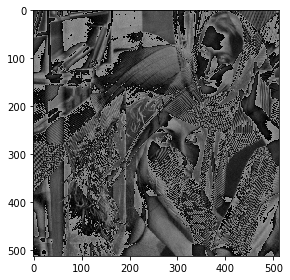

In [5]:
ski.io.imshow(imsum(lena, barbara, overflow='mod', overflow_max=150))

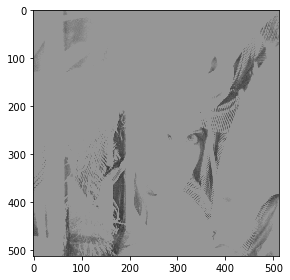

In [6]:
ski.io.imshow(imsum(lena, barbara, overflow='cap', overflow_max=150))

Veamos ahora qué sucede si hacemos el producto para distintos valores de un escalar $\alpha$ entre $-1$ y $2$, poniendo un valor máximo al producto de 255:

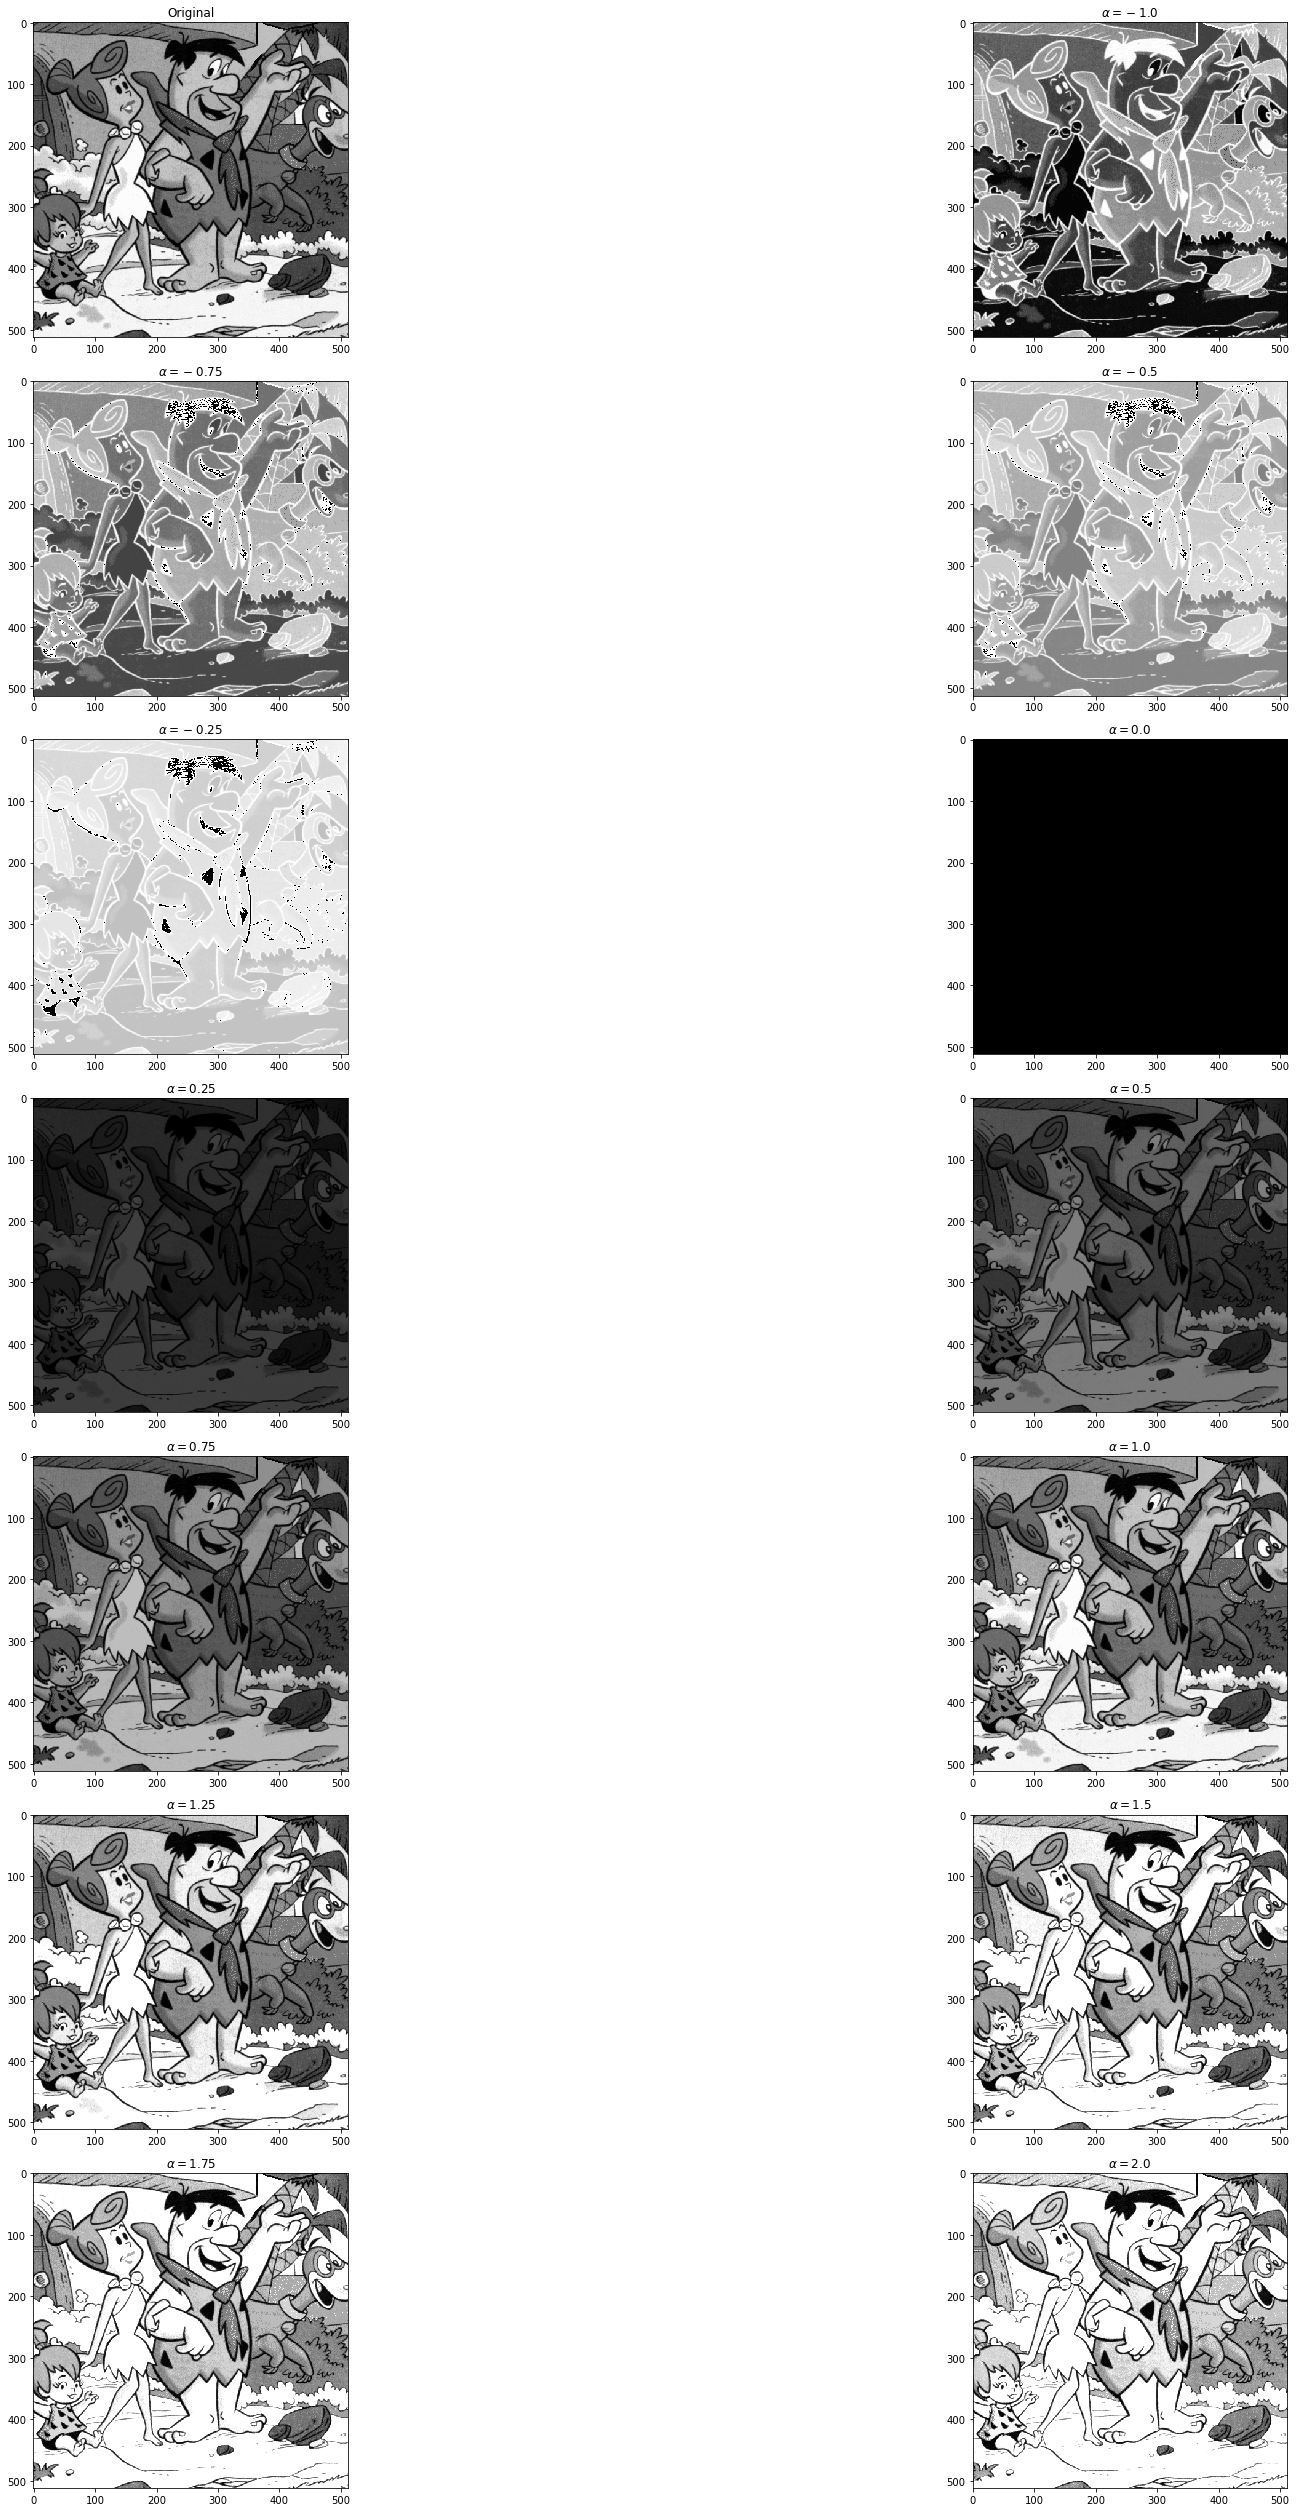

In [35]:
# Producto entre una imágen y un escalar \alpha
original = flinstones

plot_parameters(
    flinstones,
    np.arange(-1.0, 2.25, 0.25),
    lambda A, i: (improd(i, A, overflow='cap', overflow_max=255), '$\\alpha = {0}$'.format(i))
)

Observemos que tal como es esperable, a mayor valor de $\alpha$ mayor valor de brillo, y por ende las imágenes se van volviendo cada vez más "blancas"

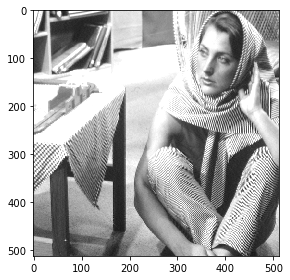

In [8]:
ski.io.imshow(improd(1.42 * np.ones((512, 512)), barbara, overflow='cap', overflow_max=255))

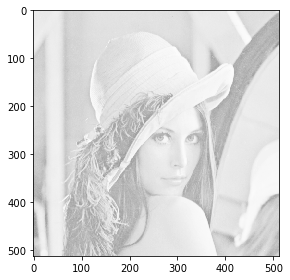

In [9]:
ski.io.imshow(dynrange(lena))

# Rango dinámico de una imágen para distintos valores de L y su correspondiente histograma.
original = flinstones

plot_parameters(
    flinstones,
    [-1, 0, 128, 256],
    lambda A, i: (improd(i, A, overflow='cap', overflow_max=255), '$\\alpha = {0}$'.format(i))
)

### Ejercicio 2

In [10]:
def imneg(A, max_value=255, **kwargs):
    '''
    Negativo de una imágen
    '''
    return imfix(max_value - A, **kwargs)

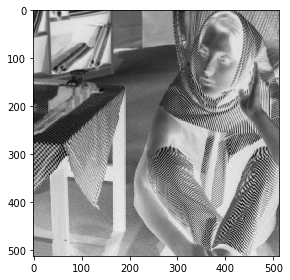

In [11]:
ski.io.imshow(imneg(barbara))

### Ejercicio 3

In [12]:
def imbinarize(A, threshold=128, max_value=255, min_value=0, **kwargs):
    '''
    Binarización de una imágen utilizando un umbral
    '''
    X = np.copy(A)
    indexes = X > threshold
    X[indexes] = max_value
    X[np.invert(indexes)] = min_value
    return imfix(X, **kwargs)

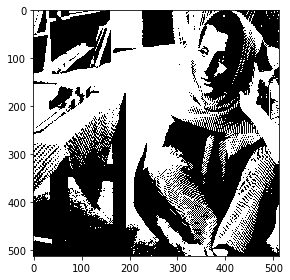

In [13]:
ski.io.imshow(imbinarize(barbara, 120))

### Ejercicio 4

In [14]:
def imbits(A):
    '''
    División de una imágen en los planos de cada bit
    '''
    # Los elementos de este arreglo son 0 o 1
    X = np.unpackbits(A.reshape((A.shape[0], A.shape[1], 1)), axis=2)
    ims = []
    for i in range(8):
        # Binarizamos la imágen para poder ver la diferencia
        ims.append(imbinarize(X[:,:,i], threshold=0))
    return np.array(ims)

def implotbitplanes(A):
    '''
    Ploteo de los planos de bits de una imágen `A`
    '''
    return imshow_all(imbits(A), shape=(2, 4), titles=['Bit {0}'.format(9 - i) for i in range(1,9)])

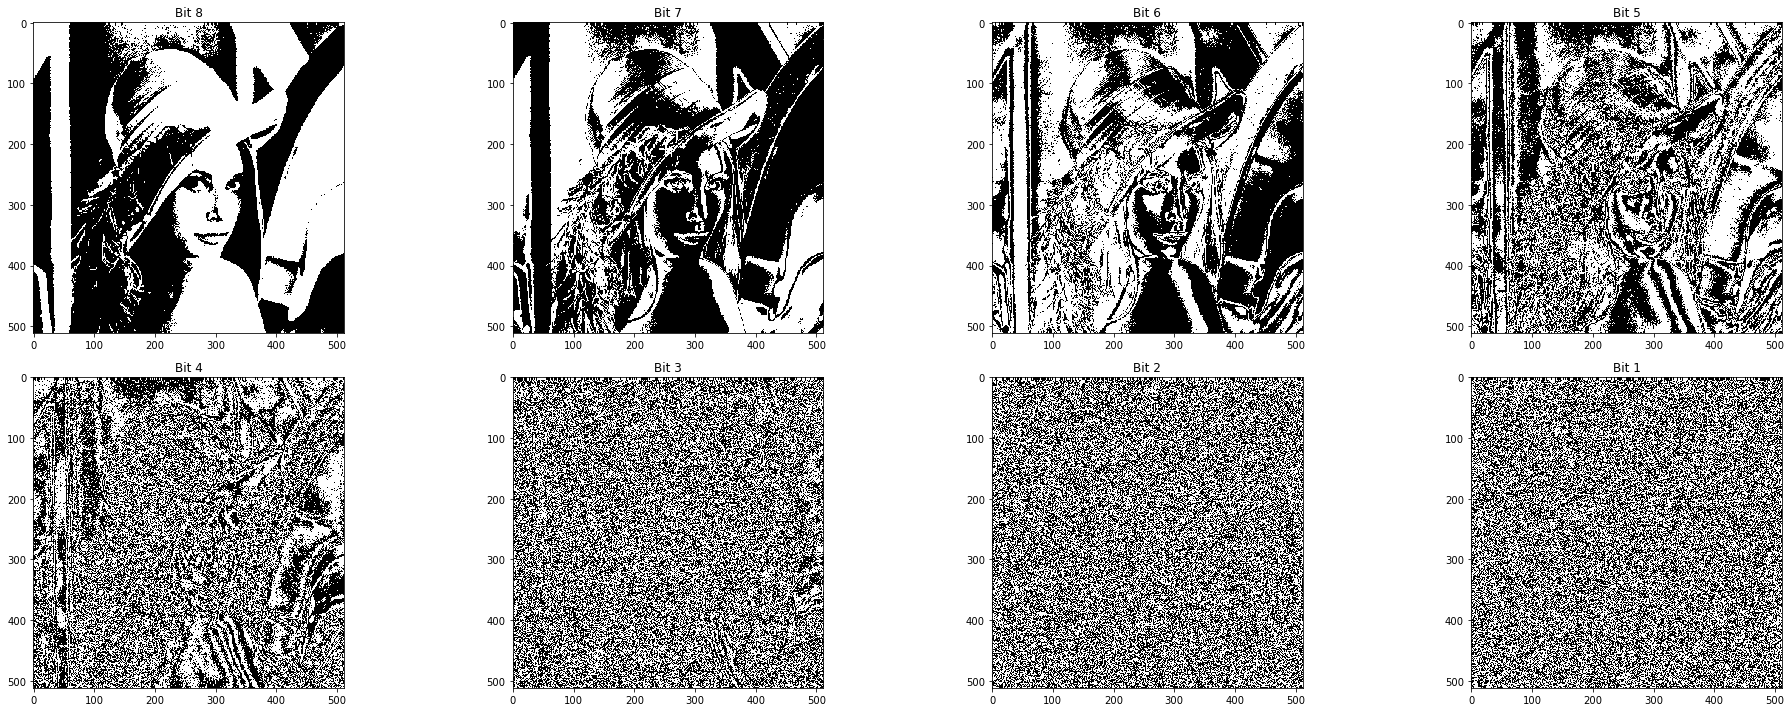

In [15]:
implotbitplanes(lena)

### Ejercicio 5

In [16]:
def imcountarr(A):
    '''
    Computa un arreglo de cantidad de píxeles para cada brillo
    '''
    # Usamos uint64, porque es un conteo de número de píxeles
    counts = np.zeros(shape=(256,), dtype=np.uint64)
    for row in A:
        for element in row:
            counts[element] += 1
    return counts

def imrelfreq(A):
    '''
    Computa un arreglo de frecuencias relativas para cada brillo
    '''
    return imcountarr(A).astype(np.double) / np.prod(A.shape, dtype=np.double)

def imhist(A, title=None):
    '''
    Dibuja el histograma de brillos
    '''
    Ns = imrelfreq(A)
    plt.bar(np.arange(256), Ns, 1)
    if title is not None:
        plt.title(title)
    plt.show()

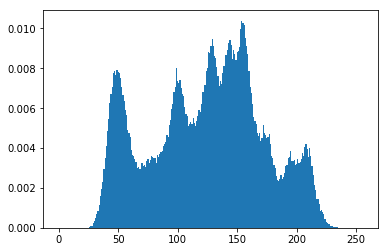

In [17]:
imhist(lena)

### Ejercicios 6, 7, y 8

In [18]:
def imhisttrans(A, T):
    '''
    Aplica una transformación de brillos T a una imágen A
    '''
    assert T.shape == (256,)
    return np.take(T, A)

def cumhist(P):
    '''
    Computa un arreglo de sumas parciales de todos los índices menores.
    '''
    S = np.zeros(shape=(len(P),), dtype=np.double)
    cumulative = 0.0
    for i in range(len(P)):
        cumulative += P[i]
        S[i] = cumulative
    return S

def imcumrelfreq(A):
    '''
    Computa un arreglo de sumas parciales de frecuencias relativas para todos los brillos. Es decir, la función de
    distribución acumulada.
    '''
    return cumhist(imrelfreq(A))

def imcumhist(A, title=None):
    '''
    Dibuja el histograma de la función de distribución acumulada para los brillos
    '''
    Hs = imcumrelfreq(A)
    plt.bar(np.arange(256), Hs, 1)
    plt.ylim((0.0, 1.0))
    if title is not None:
        plt.title(title)
    plt.show()

def imaucontrast(A, L=256):
    '''
    Linearización de histogramas
    '''
    T = (L - 1) * imcumrelfreq(A)
    T = np.floor(T)
    return imhisttrans(A, T).astype(np.uint8)

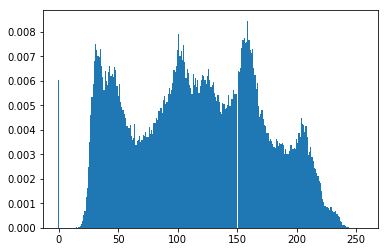

In [19]:
T = np.arange(256)
T[150] = 0
imhist(imhisttrans(barbara, T))

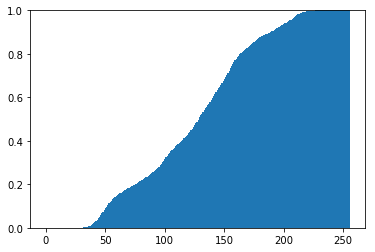

In [20]:
imcumhist(lena)

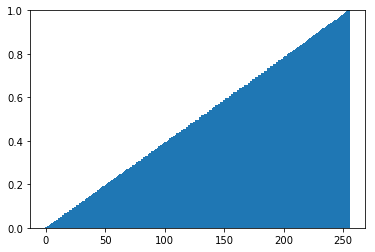

In [21]:
imcumhist(imaucontrast(lena))

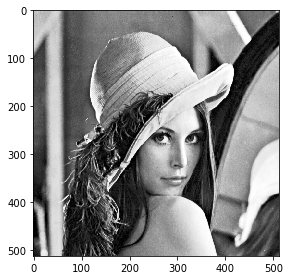

In [22]:
ski.io.imshow(imaucontrast(lena))

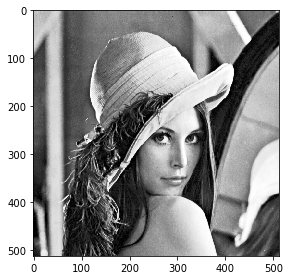

In [23]:
ski.io.imshow(imaucontrast(imaucontrast(lena)))

### Ejercicio 9

In [24]:
'''
Convierte el histograma de brillos de `A en el histograma de brillos acumulado especificado por `E`.
Opcionalmente, puede especificarse el histograma de `A` como `R`.
'''
def imspecmatching(A, E, R = None):
    assert len(E) == 256
    assert E[-1] == 1.0
    
    # CDF real de los brillos de la imágen
    if R is None:
        R = imcumrelfreq(A)
    T = np.zeros(256, dtype=np.uint8)
    for g1 in range(256):
        for g2 in range(T[g1], 256):
            if E[g2] >= R[g1]:
                T[g1] = g2
                break
    return imhisttrans(A, T)

'''
Ecualiza el histograma de A en una normal con media `mean` y desvío standard `stddev`
'''
def imspecnorm(A, mean, stddev):
    # CDF esperada de los brillos de la imágen
    E = sps.norm.cdf(np.arange(256), loc=mean, scale=stddev)
    return imspecmatching(A, E)

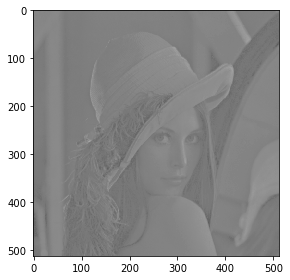

In [25]:
ski.io.imshow(imspecnorm(lena, 128, 8))

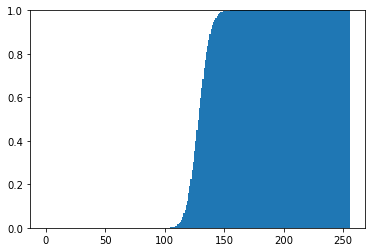

In [26]:
imcumhist(imspecnorm(lena, 128, 8))

### Ejercicio 10

In [27]:
def imresidualhist(A, lam):
    '''
    Ecualiza el histograma de `A` entre el histograma original y el histograma uniforme, regulando por el parámetro
    `lam`. A mayor `lam`, más parecido a la distribución uniforme.
    '''
    if lam == 0.0:
        return imaucontrast(A)
    
    # Observación: esta uniforme tiene que ser entre 0 y 255, sino vamos a deformar el histograma hacia el rango de la
    # uniforme a medida que vayamos aumentando lambda
    U = sps.uniform.cdf(np.arange(256), loc=0, scale=255)
    H0 = imcumrelfreq(A)
    E = (H0 + lam * U) / (1 + lam)
    return imspecmatching(A, E, H0)

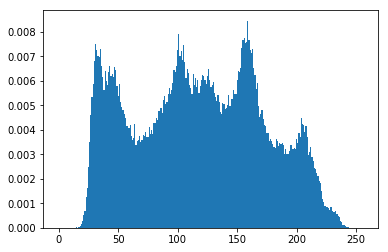

In [28]:
imhist(barbara)

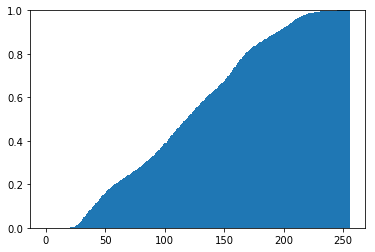

In [29]:
imcumhist(imresidualhist(barbara, 0.01))

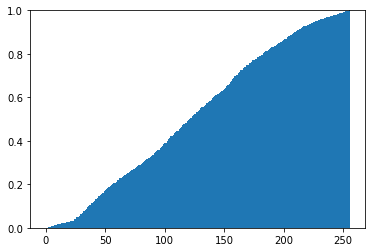

In [30]:
imcumhist(imresidualhist(barbara, 0.7))

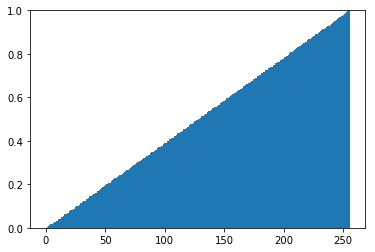

In [31]:
imcumhist(imresidualhist(barbara, 1000))